In [1]:
import scanpy as sc
import surgeon
import numpy as np
sc.settings.set_figure_params(dpi=200)

Using TensorFlow backend.


In [2]:
condition_key = "study"
cell_type_key = 'cell_type'
target_condition = "Drop-seq"

# Loading 6 PBMC datasets and data preparation

In [3]:
adata = sc.read("./data/pbmc/pbmc_count.h5ad")
adata

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


AnnData object with n_obs × n_vars = 107248 × 1793 
    obs: 'CBC', 'CellType', 'Experiment', 'Method', 'batch', 'bulk_labels', 'cell_type', 'louvain', 'method', 'n_counts', 'n_genes', 'percent_mito', 'study'
    var: 'ENS-0', 'Name-0', 'gene_ids-1', 'n_counts-2', 'gene_ids-3', 'n_cells-3', 'highly_variable-3', 'means-3', 'dispersions-3', 'dispersions_norm-3'
    uns: 'cell_type_colors', 'neighbors', 'study_colors'
    obsm: 'X_pca', 'X_umap'

## Number of cells in each batch

In [4]:
adata.obs[condition_key].value_counts()

10x PBMC 68k         68579
10X_3prime            8098
10X_5prime            7378
inDrops               6584
Drop-seq              6584
10x Chromium V2 B     3222
10x Chromium V2 A     3222
10x PBMC 3k           2638
Smart-seq2             526
CEL-Seq2               417
Name: study, dtype: int64

## visualization  of the original data

In [12]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

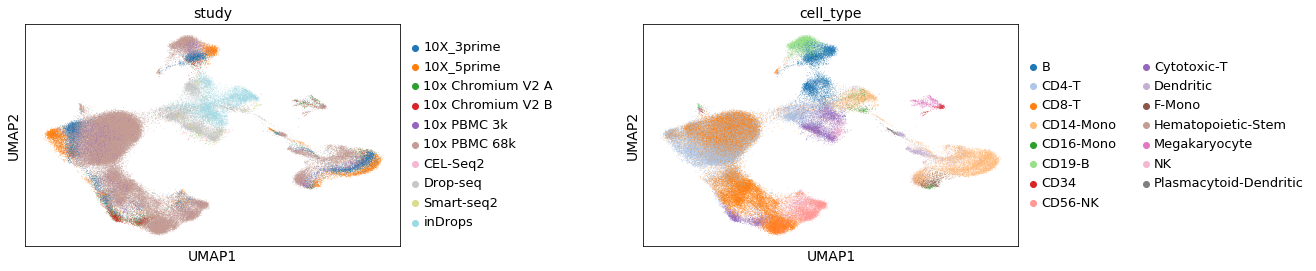

In [13]:
sc.pl.umap(adata, color=[condition_key, cell_type_key], wspace=0.5)

## Now we leave out one study  (Drop-seq) for training the newtork

In [5]:
adata_for_training = adata[adata.obs[condition_key] != target_condition]
adata_for_training

View of AnnData object with n_obs × n_vars = 100664 × 1793 
    obs: 'CBC', 'CellType', 'Experiment', 'Method', 'batch', 'bulk_labels', 'cell_type', 'louvain', 'method', 'n_counts', 'n_genes', 'percent_mito', 'study'
    var: 'ENS-0', 'Name-0', 'gene_ids-1', 'n_counts-2', 'gene_ids-3', 'n_cells-3', 'highly_variable-3', 'means-3', 'dispersions-3', 'dispersions_norm-3'
    uns: 'cell_type_colors', 'neighbors', 'study_colors'
    obsm: 'X_pca', 'X_umap'

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


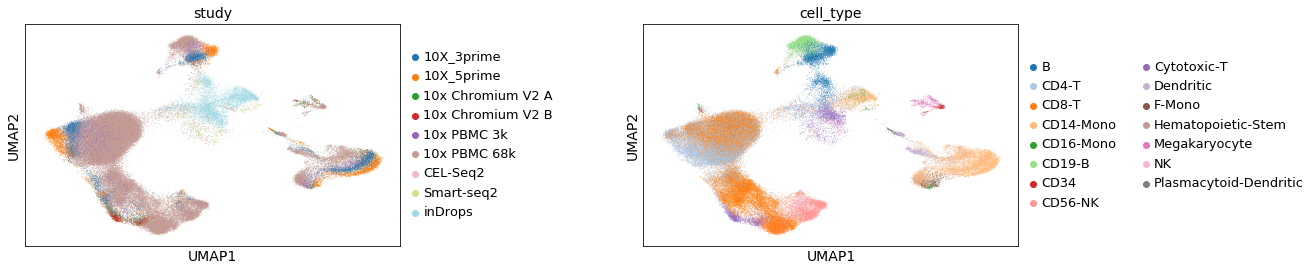

In [15]:
sc.pl.umap(adata_for_training, color=[condition_key, cell_type_key], wspace=0.5)

In [6]:
adata_out_of_sample = adata[adata.obs[condition_key] == target_condition]
adata_out_of_sample

View of AnnData object with n_obs × n_vars = 6584 × 1793 
    obs: 'CBC', 'CellType', 'Experiment', 'Method', 'batch', 'bulk_labels', 'cell_type', 'louvain', 'method', 'n_counts', 'n_genes', 'percent_mito', 'study'
    var: 'ENS-0', 'Name-0', 'gene_ids-1', 'n_counts-2', 'gene_ids-3', 'n_cells-3', 'highly_variable-3', 'means-3', 'dispersions-3', 'dispersions_norm-3'
    uns: 'cell_type_colors', 'neighbors', 'study_colors'
    obsm: 'X_pca', 'X_umap'

## Normalization

In [7]:
adata_for_training = surgeon.utils.normalize(adata_for_training, 
                                             filter_min_counts=False, 
                                             normalize_input=False, 
                                             size_factors=True,
                                             logtrans_input=True,
                                             n_top_genes=2000,
                                            )

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Trying to set attribute `.obs` of view, making a copy.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [8]:
adata_out_of_sample = surgeon.utils.normalize(adata_out_of_sample, 
                                              filter_min_counts=False, 
                                              normalize_input=False, 
                                              size_factors=True,
                                              logtrans_input=True,
                                              n_top_genes=2000,
                                             )

Trying to set attribute `.obs` of view, making a copy.


## Train/Test Split

In [9]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_for_training, 0.85)

In [10]:
train_adata.shape, valid_adata.shape

((85564, 1793), (15100, 1793))

In [11]:
n_conditions = len(train_adata.obs[condition_key].unique().tolist())

# Create & Train model with training data

In [12]:
network = surgeon.archs.CVAE(x_dimension=train_adata.shape[1], 
                             z_dimension=80,
                             n_conditions=n_conditions,
                             lr=0.001,
                             alpha=0.0001,
                             scale_factor=1.0,
                             clip_value=5.0,
                             loss_fn='nb',
                             model_path="./models/CVAE/Pancreas/",
                             dropout_rate=0.2,
                             )

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/home/mohsen/scnet/surgeon/models/_cvae.py:146: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
  output=h_disp)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 1793)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 9)            0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 1802)         0           data[0][0]                       
                                                                 encoder_labels[0][0]             
__________________________________________________________________________________________________
first_layer (Dense)             (None, 512)          922624      concatenate_1[0][0]              
__________

## We assign each study to a numerical label 

In [13]:
condition_encoder = {'10x PBMC 68k': 0, '10X_3prime': 1, '10X_5prime': 2, 'inDrops': 3, 
                     "10x Chromium V2 B": 4, '10x Chromium V2 A': 5, '10x PBMC 3k': 6,
                     'Smart-seq2': 7, 'CEL-Seq2': 8}

## Training the network

In [ ]:
network.train(train_adata,
              valid_adata, 
              condition_key=condition_key,
              le=condition_encoder, 
              n_epochs=10000,
              batch_size=32, 
              early_stop_limit=50,
              lr_reducer=25, 
              save=False, 
              verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 85564 samples, validate on 15100 samples
Epoch 1/10000
 - 19s - loss: 0.2701 - nb: 0.2701 - val_loss: 0.2577 - val_nb: 0.2577
Epoch 2/10000
 - 17s - loss: 0.2584 - nb: 0.2584 - val_loss: 0.2543 - val_nb: 0.2543
Epoch 3/10000
 - 18s - loss: 0.2555 - nb: 0.2555 - val_loss: 0.2522 - val_nb: 0.2522
Epoch 4/10000
 - 17s - loss: 0.2541 - nb: 0.2541 - val_loss: 0.2514 - val_nb: 0.2514
Epoch 5/10000
 - 17s - loss: 0.2531 - nb: 0.2531 - val_loss: 0.2508 - val_nb: 0.2508
Epoch 6/10000
 - 17s - loss: 0.2524 - nb: 0.2524 - val_loss: 0.2501 - val_nb: 0.2501
Epoch 7/10000
 - 17s - loss: 0.2519 - nb: 0.2519 - val_loss: 0.2499 - val_nb: 0.2499
Epoch 8/10000
 - 17s - loss: 0.2514 - nb: 0.2514 - val_loss: 0.2494 - val_nb: 0.2494
Epoch 9/10000
 - 18s - loss: 0.2511 - nb: 0.2511 - val_loss: 0.2493 - val_nb: 0.2493
Epoch 10/10000
 - 17s - loss: 0.2507 - nb: 0.2507 - val_loss: 0.2491 - val_nb: 0.2491
Epoch 11/10000
 - 17s - loss: 0.2505 - nb: 0.2505 -

In [15]:
network.condition_encoder

{'inDrops': 0,
 '10x Chromium V2 B': 1,
 '10x Chromium V2 A': 2,
 'Smart-seq2': 3,
 'CEL-Seq2': 4}

In [16]:
encoder_labels, _ = surgeon.utils.label_encoder(
    train_adata, label_encoder=network.condition_encoder, condition_key=condition_key)

In [17]:
latent_adata = network.to_latent(train_adata, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 11875 × 20 
    obs: 'Experiment', 'Method', 'CBC', 'CellType', 'n_counts', 'size_factors'

In [18]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

/home/icb/mohsen.naghipourfar/.local/lib/python3.6/site-packages/umap/rp_tree.py:450: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "make_euclidean_tree" failed type inference due to: Cannot unify RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none) and RandomProjectionTreeNode(none, bool, array(float32, 1d, C), float64, RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none), RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none)) for '$14.16', defined at /home/icb/mohsen.naghipourfar/.local/lib/python3.6/site-packages/umap/rp_tree.py (457)

File "../.local/lib/python3.6/site-packages/umap/rp_tree.py", line 457:
def make_euclidean_tree(data, indices, rng_state, leaf_size=30):
    <source elided>

        left_node = make_euclidean_tree(data, left_indices, rng_state, leaf_size)
        ^

[1] During: resolving callee type: recursive(type(CPUDispatcher(<function make_euc

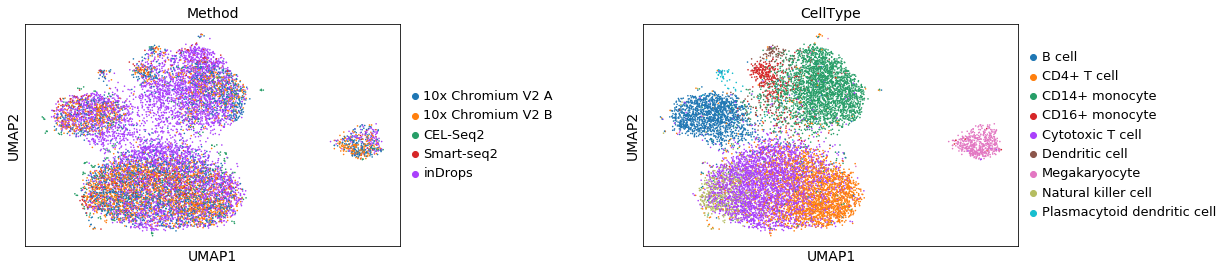

In [19]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], wspace=0.5)

# Perfroming architecture Surgery

In [20]:
new_network = surgeon.operate(network, 
                              new_condition=target_condition,
                              init='Xavier', 
                              freeze=True)

/home/icb/mohsen.naghipourfar/scnet/surgeon/models/_cvae.py:146: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
  output=h_disp)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 2000)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 6)            0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 2006)         0           data[0][0]                       
                                                                 encoder_labels[0][0]             
__________________________________________________________________________________________________
first_layer (Dense)             (None, 512)          1027072     concatenate_3[0][0]              
__________

In [21]:
new_network.condition_encoder

{'inDrops': 0,
 '10x Chromium V2 B': 1,
 '10x Chromium V2 A': 2,
 'Smart-seq2': 3,
 'CEL-Seq2': 4,
 'Drop-seq': 5}

## Train with small new dataset containing out-of-sample condition

In [22]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_out_of_sample, 0.85)

In [23]:
train_adata.shape, valid_adata.shape

((5596, 2000), (988, 2000))

In [24]:
new_network.train(train_adata,
                  valid_adata, 
                  condition_key=condition_key,
                  le=new_network.condition_encoder, 
                  n_epochs=300,
                  batch_size=32, 
                  early_stop_limit=30,
                  lr_reducer=20, 
                  save=False, 
                  verbose=2)

Train on 5596 samples, validate on 988 samples
Epoch 1/300
 - 5s - loss: 0.6142 - nb: 0.6142 - val_loss: 0.4250 - val_nb: 0.4250
Epoch 2/300
 - 4s - loss: 0.5390 - nb: 0.5390 - val_loss: 0.4366 - val_nb: 0.4366
Epoch 3/300
 - 4s - loss: 0.5109 - nb: 0.5109 - val_loss: 0.4420 - val_nb: 0.4420
Epoch 4/300
 - 4s - loss: 0.4913 - nb: 0.4913 - val_loss: 0.4374 - val_nb: 0.4374
Epoch 5/300
 - 4s - loss: 0.4788 - nb: 0.4788 - val_loss: 0.4384 - val_nb: 0.4384
Epoch 6/300
 - 4s - loss: 0.4685 - nb: 0.4685 - val_loss: 0.4330 - val_nb: 0.4330
Epoch 7/300
 - 4s - loss: 0.4605 - nb: 0.4605 - val_loss: 0.4252 - val_nb: 0.4252
Epoch 8/300
 - 4s - loss: 0.4531 - nb: 0.4531 - val_loss: 0.4258 - val_nb: 0.4258
Epoch 9/300
 - 4s - loss: 0.4461 - nb: 0.4461 - val_loss: 0.4203 - val_nb: 0.4203
Epoch 10/300
 - 4s - loss: 0.4414 - nb: 0.4414 - val_loss: 0.4165 - val_nb: 0.4165
Epoch 11/300
 - 4s - loss: 0.4377 - nb: 0.4377 - val_loss: 0.4147 - val_nb: 0.4147
Epoch 12/300
 - 4s - loss: 0.4327 - nb: 0.4327 - 

In [25]:
adata = surgeon.utils.normalize(adata, 
                                filter_min_counts=False, 
                                normalize_input=False, 
                                size_factors=True,
                                logtrans_input=True,
                                n_top_genes=2000,
                                )

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [26]:
encoder_labels, _ = surgeon.utils.label_encoder(adata, label_encoder=new_network.condition_encoder, condition_key=condition_key)

In [27]:
adata.obs[condition_key].value_counts()

inDrops              6584
Drop-seq             6584
10x Chromium V2 B    3222
10x Chromium V2 A    3222
Smart-seq2            526
CEL-Seq2              417
Name: Method, dtype: int64

In [28]:
latent_adata = new_network.to_latent(adata, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 20555 × 20 
    obs: 'Experiment', 'Method', 'CBC', 'CellType', 'n_counts', 'size_factors'

In [29]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

/home/icb/mohsen.naghipourfar/.local/lib/python3.6/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../.local/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


In [ ]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], wspace=0.5)